<a href="https://colab.research.google.com/github/lkforward/I_know_the_cloud/blob/master/run_cloud_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
!pip install catalyst
!pip install pretrainedmodels
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install pytorch_toolbelt
!pip install torchvision==0.4
!pip install albumentations==0.3.2

     |████████████████████████████████| 286kB 6.7MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 460kB 42.6MB/s 
     |████████████████████████████████| 194kB 51.7MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


     |████████████████████████████████| 61kB 3.7MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=2498de4ffe735a48f4529873ef85bd6b0e76004e39bc58db5fcd29da1f895e13
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-oofgbl4c
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-oofgbl4c
     |████████████████████████████████| 8.8MB 6.5MB/s 
     |████████████████████████████████| 748.9MB 22kB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.0.3-cp36-none-any.whl size=29990 sha256=9890f65ea42115824003dffd0399dbb50e0f57d36e69577bec3a7be1dc570ca3
  Stored in directory: /tmp/pip-ephem-wheel-cache-tl8wwxe6/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4

In [0]:
import os
import cv2
import collections
import time 
import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import torch as AT

In [0]:
from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.dl.runner import SupervisedRunner
from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback

import segmentation_models_pytorch as smp

# Mount the google drive

In [6]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
!pwd

/content


# Helper Functions



In [0]:
def get_img(x, folder: str='train_images'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{path}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """
    Create mask based on df, image name and shape.

    [OUTPUTS]:
    masks: an array with shape (shape[0], shape[1], 4).
      Mask for each class labels.
    """
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :, idx] = mask
            
    return masks


def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')


def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)
        
        
        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)
            
            
def visualize_with_raw(image, mask, original_image=None, original_mask=None, raw_image=None, raw_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)


    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mask[:, :, i])
        ax[1, i + 1].set_title(f'Raw predicted mask {class_dict[i]}', fontsize=fontsize)
        
    ax[2, 0].imshow(image)
    ax[2, 0].set_title('Transformed image', fontsize=fontsize)


    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(f'Predicted mask with processing {class_dict[i]}', fontsize=fontsize)
            
            
def plot_with_augmentation(image, mask, augment):
    """
    Wrapper for `visualize` function.
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)

  
    
sigmoid = lambda x: 1 / (1 + np.exp(-x))


def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    # don't remember where I saw it
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


def get_training_augmentation():
    """
    Define the preprocessing for the training data. 
    """
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        albu.GridDistortion(p=0.5),
        albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        albu.Resize(320, 640)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 640)
    ]
    return albu.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.augmentations.transforms.Lambda(image=preprocessing_fn),
        albu.augmentations.transforms.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())

# Load Dataset

In [0]:
path = '/content/gdrive/My Drive/kaggle_cloud/data'


def get_data(path, n_samples=None):
  """
  Read the taining data information, including image id and labels. 
  """
  train = pd.read_csv(f'{path}/train.csv')
  sub = pd.read_csv(f'{path}/sample_submission.csv')
  print("Reading the training csv...")
  print(train.columns)
  print(train.shape)

  n_train = len(os.listdir(f'{path}/train_images'))
  print("Reading the training images...")
  print(f'There are {n_train} images in the original train dataset')

  if n_samples: 
    train = train.iloc[:n_samples, :]
    print(f'Use {n_samples} images within the training dataset.')


  train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
  train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

  sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
  sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

  return train, sub


def display_images_with_masks(path, train):
  """
  Randomly choose 4 images from the training dataset, and plot them with the masks.
  """

  fig = plt.figure(figsize=(25, 16))
  for j, im_id in enumerate(np.random.choice(train['im_id'].unique(), 4)):
      for i, (idx, row) in enumerate(train.loc[train['im_id'] == im_id].iterrows()):
          ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
          im = Image.open(f"{path}/train_images/{row['Image_Label'].split('_')[0]}")
          plt.imshow(im)
          mask_rle = row['EncodedPixels']
          try: # label might not be there!
              mask = rle_decode(mask_rle)
          except:
              mask = np.zeros((1400, 2100))
          plt.imshow(mask, alpha=0.5, cmap='gray')
          ax.set_title(f"Image: {row['Image_Label'].split('_')[0]}. Label: {row['label']}")


def split_data(train, sub):
  """
  Split the training dataset into train/valid datasets, and use all the data in 
  the submission dataset as test data. 

  [OUTPUTS]:
  train_ids/valid_ids/test_ids: array of image ids(str). 
  """
  train_labels = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label']
  id_mask_count = train_labels.apply(lambda x: x.split('_')[0]).value_counts()
  id_mask_count = id_mask_count.reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'})
  train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values,
                                          random_state=42,
                                          stratify=id_mask_count['count'],
                                          test_size=0.1)
 
  # Alternatively, we can use sub['im_id'] directly. 
  test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values
  
  return train_ids, valid_ids, test_ids


class CloudDataset(Dataset):
    def __init__(self, df: pd.DataFrame = None, datatype: str = 'train', img_ids: np.array = None,
                 transforms = albu.Compose([albu.HorizontalFlip(),AT.ToTensor()]),
                 preprocessing=None):
        """
        [INPUTS]:
        df: a pandas dataframe. 
          The image information dataframe, obtained from function "get_data()".
        datatype: string. 
          Whether it is 'train' or 'test'. 
        
        """
        self.df = df
        if datatype != 'test':
            self.data_folder = f"{path}/train_images"
        else:
            self.data_folder = f"{path}/test_images"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
        return img, mask

    def __len__(self):
        return len(self.img_ids)

In [20]:
train, sub = get_data(path)

Reading the training csv...
Index(['Image_Label', 'EncodedPixels'], dtype='object')
(22184, 2)
Reading the training images...
There are 5546 images in the original train dataset


In [21]:
print(train.shape)
train.head()

(22184, 4)


,Image_Label,EncodedPixels,label,im_id
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,Fish,0011165.jpg
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,Flower,0011165.jpg
2,0011165.jpg_Gravel,NaN,Gravel,0011165.jpg
3,0011165.jpg_Sugar,NaN,Sugar,0011165.jpg
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,Fish,002be4f.jpg


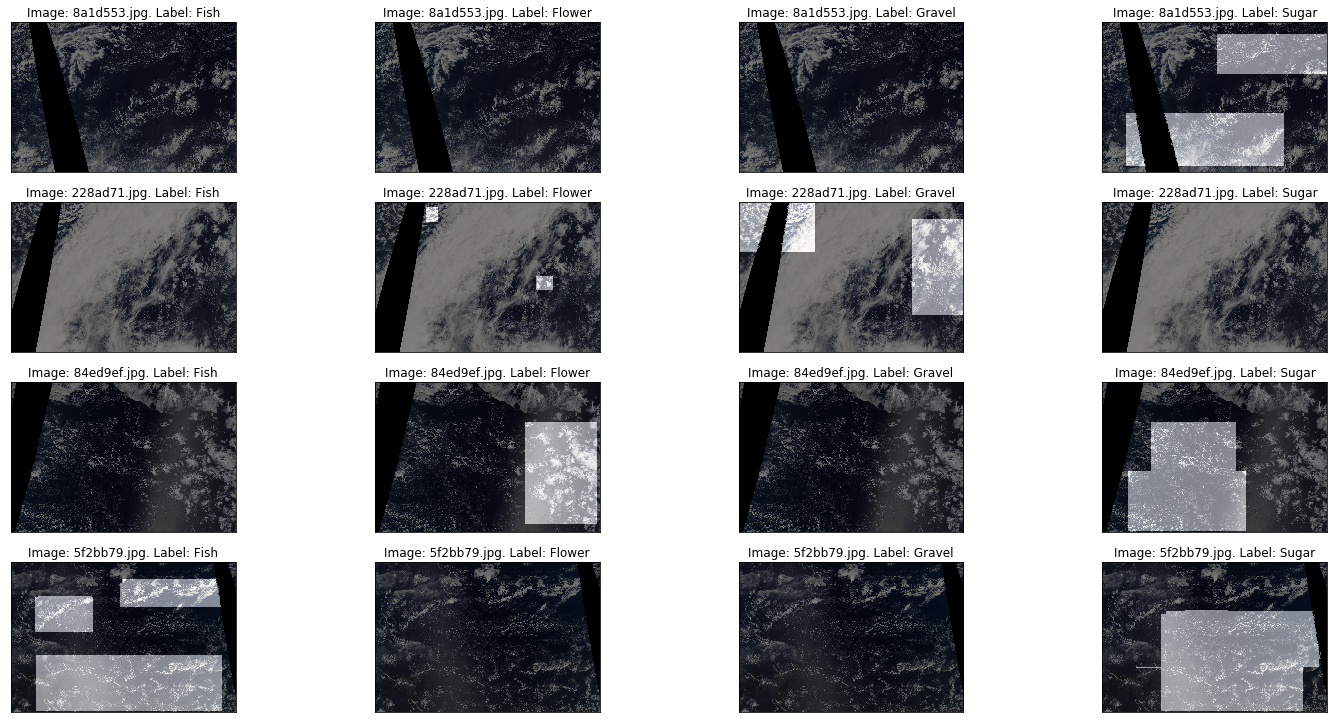

In [22]:
display_images_with_masks(path, train)

In [23]:
train_ids, valid_ids, test_ids = split_data(train, sub)

print('The size of training sample:', train_ids.shape)
print('The size of validation sample:', valid_ids.shape)
print('The size of testing sample:', test_ids.shape)

The size of training sample: (4991,)
The size of validation sample: (555,)
The size of testing sample: (3698,)


# Build the Model

In [25]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

num_workers = 0
bs = 16
train_dataset = CloudDataset(df=train, datatype='train', img_ids=train_ids, 
                             transforms = get_training_augmentation(), 
                             preprocessing=get_preprocessing(preprocessing_fn))

valid_dataset = CloudDataset(df=train, datatype='valid', img_ids=valid_ids, 
                             transforms = get_validation_augmentation(), 
                             preprocessing=get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, 
                          num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, 
                          num_workers=num_workers)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 28.8MB/s]
/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2247: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().

